<a href="https://colab.research.google.com/github/GlubokovK/DL_CholletF_open/blob/master/Sholle_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Глава 6

###  Пример обработки отзывов IMDB (embending + dense)

#### 6.1.1. Прямое кодирование слов и символов

In [0]:
# Листинг 6.1. Прямое кодирование на уровне слов (упрощенный пример)
import numpy as np
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
# Исходные данные: один элемент — один образец 
# (в данном случае образцы представляют по одному предложению, 
# но точно так же это могли бы быть целые документы)


token_index = {}
for sample in samples: 
  for word in sample.split(): 
    if word not in token_index: 
      token_index[word] = len(token_index) + 1
      
# Векторизация образцов. В каждом образце рассматриваются только первые max_length слов
max_length = 10 


results = np.zeros(shape=(len(samples), 
                          max_length, 
                          max(token_index.values()) + 1)
                  ) 

for i, sample in enumerate(samples): 
  for j, word in list(enumerate(sample.split()))[:max_length]: 
    index = token_index.get(word) 
    results[i, j, index] = 1.

In [0]:
# Листинг 6.2. Прямое кодирование на уровне символов (упрощенный пример)
import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable # Все отображаемые символы ASCII
token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50

results = np.zeros((len(samples), 
                    max_length, 
                    max(token_index.values()) + 1
                   ))

for i, sample in enumerate(samples):
  for j, character in enumerate(sample):
    index = token_index.get(character)
    results[i, j, index] = 1.

In [0]:
# Листинг 6.3. Использование Keras для прямого кодирования слов

from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=1000) # Создание токенизатора и его настройка на учет только 1000 наиболее часто используемых слов
tokenizer.fit_on_texts(samples) # Обучаем токенайзер на тексте. Создание индекса всех слов

sequences = tokenizer.texts_to_sequences(samples) # Преобразование строк в списки целочисленных индексов

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary') 

word_index = tokenizer.word_index 
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 9 unique tokens.


In [0]:
sequences

[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]

In [0]:
len(one_hot_results[0])

1000

In [0]:
# Листинг 6.4. Прямое кодирование на уровне слов с использованием хеширования (упрощенный пример)
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

dimensionality = 1000 # Слова будут сохраняться как векторы с размером 1000. 
# Если число слов близко к 1000 (или даже больше), 
# вы увидите множество хеш-коллизий, 
# снижающих точность этого метода кодирования.

max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples): 
  for j, word in list(enumerate(sample.split()))[:max_length]: 
    index = abs(hash(word)) % dimensionality # Хеширование слов в случайные целочисленные индексы между 0 и 1000
    results[i, j, index] = 1.

In [0]:
results.shape

(2, 10, 1000)

#### 6.1.2. Векторное представление слов

In [0]:
# Листинг 6.5. Создание слоя Embedding
from keras.layers import Embedding
embedding_layer = Embedding(1000, 64)
# Слой Embedding принимает как минимум два аргумента: 
# количество возможных токенов (в данном случае 1000: 1 + максимальный индекс слова) 
# и размерность пространства (в данном случае 64)

In [0]:
# Листинг 6.6. Загрузка данных из IMDB для передачи в слой Embedding
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000 # Количество слов, рассматриваемых как признаки
maxlen = 20 # Обрезка текста после этого количества слов (в числе max_features самых распространенных слов)

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features) # Загрузка данных как списков целых чисел


x_train1 = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen) # Преобразование списков целых чисел 
# в двумерный тензор с целыми числами и с формой (образцы, максимальная_длина)
x_test1 = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)



In [0]:
print(x_train.shape)
print('x_train[0] = {}'.format(x_train[2]))
print(len(x_train[2]))

print(x_train1.shape)
print('x_train[0] = {}'.format(x_train1[2]))
print(len(x_train1[2]))

(25000,)
x_train[0] = [1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 5974, 54, 61, 369, 13, 71, 149, 14, 22, 112, 4, 2401, 311, 12, 16, 3711, 33, 75, 43, 1829, 296, 4, 86, 320, 35, 534, 19, 263, 4821, 1301, 4, 1873, 33, 89, 78, 12, 66, 16, 4, 360, 7, 4, 58, 316, 334, 11, 4, 1716, 43, 645, 662, 8, 257, 85, 1200, 42, 1228, 2578, 83, 68, 3912, 15, 36, 165, 1539, 278, 36, 69, 2, 780, 8, 106, 14, 6905, 1338, 18, 6, 22, 12, 215, 28, 610, 40, 6, 87, 326, 23, 2300, 21, 23, 22, 12, 272, 40, 57, 31, 11, 4, 22, 47, 6, 2307, 51, 9, 170, 23, 595, 116, 595, 1352, 13, 191, 79, 638, 89, 2, 14, 9, 8, 106, 607, 624, 35, 534, 6, 227, 7, 129, 113]
141
(25000, 20)
x_train[0] = [1352   13  191   79  638   89    2   14    9    8  106  607  624   35
  534    6  227    7  129  113]
20


In [0]:
# Листинг 6.7. Использование слоя Embedding и классификатора данных из IMDB

from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen)) 
# Определение максимальной длины входа для слоя Embedding 
# в целях последующего уменьшения размерности. После слоя Embedding 
# активация имеет форму (образцы, максимальная_длина(20), 8)


model.add(Flatten()) 

model.add(Dense(1, activation='sigmoid')) # Добавление классификатора сверху
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train1, 
                    y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_split=0.2)





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 128us/step - loss: 0.6684 - acc: 0.6189 - val_loss: 0.6113 - val_acc: 0.7038
Epoch 2/10
20000/20000 [==============================] - 1s 66us/step - loss: 0.5349 - acc: 0.7540 - val_loss: 0.5196 - val_acc: 0.7336
Epoch 3/10
20000/20000 [======

#### 6.1.3. Объединение всего вместе: от исходного текста к векторному представлению слов

In [10]:
!wget --no-check-certificate \
    http://mng.bz/0tIo \
    -O /tmp/acllmdb.zip

--2019-02-24 07:50:25--  http://mng.bz/0tIo
Resolving mng.bz (mng.bz)... 35.166.24.88
Connecting to mng.bz (mng.bz)|35.166.24.88|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://mng.bz/0tIo [following]
--2019-02-24 07:50:25--  https://mng.bz/0tIo
Connecting to mng.bz (mng.bz)|35.166.24.88|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 301 
Location: http://s3.amazonaws.com/text-datasets/aclImdb.zip [following]
--2019-02-24 07:50:25--  http://s3.amazonaws.com/text-datasets/aclImdb.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.238.141
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.238.141|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60711700 (58M) [application/zip]
Saving to: ‘/tmp/acllmdb.zip’

/tmp/acllmdb.zip    100%[===================>]  57.90M  6.88MB/s    in 17s     

2019-02-24 07:50:43 (3.31 MB/s) - ‘/tmp/acllmdb.zip’

In [0]:
import os
import zipfile

local_zip = '/tmp/acllmdb.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/data_acllmdb/')
zip_ref.close()

In [12]:
import os
print(os.listdir('/tmp'))

['data', 'acllmdb.zip', 'dogscats', 'data_acllmdb']


In [0]:
# Листинг 6.8. Обработка меток из исходного набора данных IMDB
import os

imdb_dir = '/tmp/data_acllmdb/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

In [32]:
print(len(texts))
print(len(labels))

25000
25000


In [33]:
# Листинг 6.9. Токенизация текста из исходного набора данных IMDB
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # Отсечение остатка отзывов после 100-го слова
training_samples = 200 # Обучение на выборке из 200 образцов
validation_samples = 10000 # Проверка на выборке из 10 000 образцов
max_words = 10000 # Рассмотрение только 10 000 наиболее часто используемых слов

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index # словарь word : index

print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen) #Приведение всех предложений к длинне 100
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Разбивка данных на обучающую и проверочную выборки, 
# но перед этим данные перемешиваются, поскольку отзывы в 
# исходном наборе упорядочены (сначала следуют отрицательные, 
# а потом положительные)
indices = np.arange(data.shape[0]) 
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [36]:
print('len sequences = {}'.format(len(sequences)))
print('len sequences[0] = {}'.format(len(sequences[0])))
print('len sequences[1] = {}'.format(len(sequences[1])))
sequences[0][:10]
print('x_train.shape = {}'.format(x_train.shape))
print('y_train.shape = {}'.format(y_train.shape))
print('x_val.shape = {}'.format(x_val.shape))
print('y_val.shape = {}'.format(y_val.shape))

len sequences = 25000
len sequences[0] = 419
len sequences[1] = 67
x_train.shape = (200, 100)
y_train.shape = (200,)
x_val.shape = (10000, 100)
y_val.shape = (10000,)


In [37]:
# Загрузка векторного представления GloVe

!wget --no-check-certificate \
    http://nlp.stanford.edu/data/glove.6B.zip \
    -O /tmp/glove.6B.zip

--2019-02-24 10:07:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-02-24 10:07:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’

/tmp/glove.6B.zip   100%[===================>] 822.24M   103MB/s    in 9.2s    

2019-02-24 10:08:08 (89.5 MB/s) - ‘/tmp/glove.6B.zip’ saved [862182613/862182613]



In [0]:
local_zip = '/tmp/glove.6B.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/data_glove/')
zip_ref.close()

In [42]:
# Листинг 6.10. Обработка файла с векторными представлениями слов GloVe
glove_dir = '/tmp/data_glove/'

embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [57]:
# Посмотрим что получили
i=0
for s in embeddings_index:
  print(s,embeddings_index[s][:2], 'len = ',len(embeddings_index[s]) )
  i+=1
  if i>10: break

the [-0.038194 -0.24487 ] len =  100
, [-0.10767  0.11053] len =  100
. [-0.33979  0.20941] len =  100
of [-0.1529  -0.24279] len =  100
to [-0.1897    0.050024] len =  100
and [-0.071953  0.23127 ] len =  100
in [ 0.085703 -0.22201 ] len =  100
a [-0.27086   0.044006] len =  100
" [-0.30457 -0.23645] len =  100
's [ 0.58854 -0.2025 ] len =  100
for [-0.14401  0.32554] len =  100


In [0]:
# Листинг 6.11. Подготовка матрицы векторных представлений слов GloVe
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items(): 
  if i < max_words: 
    embedding_vector = embeddings_index.get(word) 
    if embedding_vector is not None: 
      # Словам, отсутствующим в индексе представлений, 
      # будут соответствовать векторы с нулевыми зна-чениями
      embedding_matrix[i] = embedding_vector 

In [58]:
# Листинг 6.12. Определение модели
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()

model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Листинг 6.13. Загрузка предварительно обученных векторных представлений слов в слой Embedding
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [64]:
print(x_train[0][:10],len(x_train[0]), len(x_train))

[6169  523    2  254  106 2102 1307   35   12   31] 100 200


In [65]:
# Листинг 6.14. Обучение и оценка
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, 
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Instructions for updating:
Use tf.cast instead.
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 1.8754 - acc: 0.5200 - val_loss: 0.6930 - val_acc: 0.5032
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6100 - acc: 0.6500 - val_loss: 0.8479 - val_acc: 0.5026
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6029 - acc: 0.7050 - val_loss: 0.7366 - val_acc: 0.5001
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5049 - acc: 0.7600 - val_loss: 0.7285 - val_acc: 0.5242
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4244 - acc: 0.8200 - val_loss: 0.7143 - val_acc: 0.5203
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2619 - acc: 0.9450 - val_loss: 0.9274 - val_acc: 0.5054
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3446 - acc: 0.8500 - val_loss: 1.025

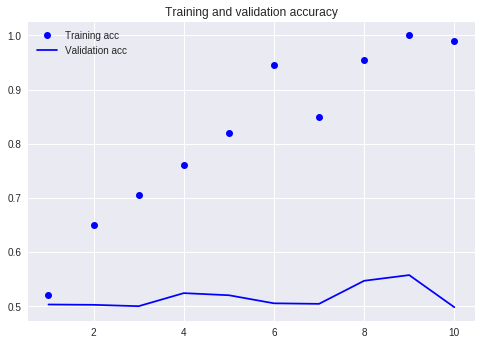

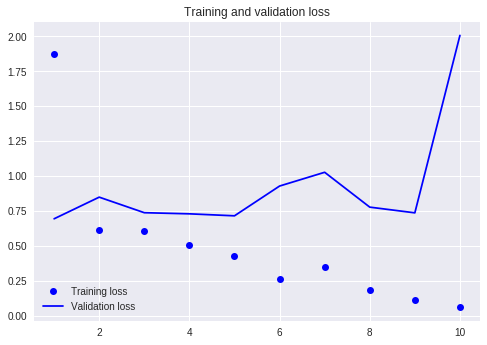

In [66]:
#Формирование графиков изменения потерь и точности в процессе обучения
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [67]:
# Листинг 6.16. Обучение той же модели без использования уже обученных
# векторных представлений
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, 
                    y_train,epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6930 - acc: 0.4850 - val_loss: 0.6948 - val_acc: 0.5035
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4617 - a

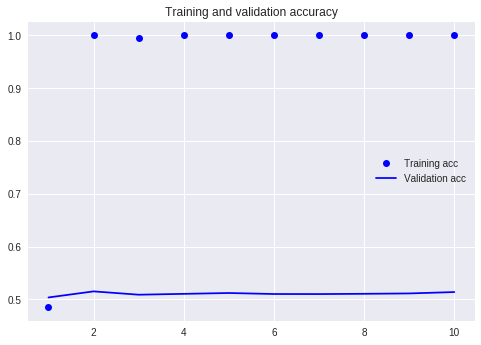

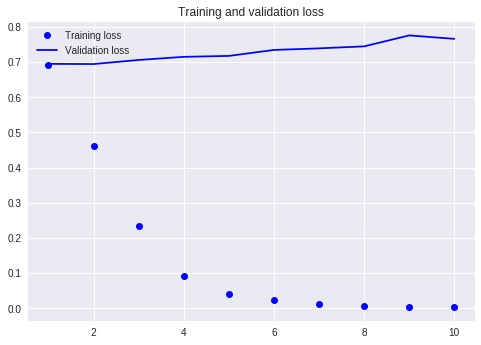

In [68]:
#Формирование графиков изменения потерь и точности в процессе обучения
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# Наконец, оценим модель на контрольной выборке.

In [0]:
# Листинг 6.17. Токенизация данных из контрольной выборки
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
  dir_name = os.path.join(test_dir, label_type)
  for fname in sorted(os.listdir(dir_name)):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)
        
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [70]:
# Листинг 6.18. Оценка модели на контрольном наборе данных
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 54us/step


[1.9852348167699576, 0.50048]

### 6.2. Рекуррентные нейронные сети (простой прмер)

In [0]:
# Листинг 6.21. Реализация сети RNN на основе Numpy
import numpy as np

timesteps = 100 # Число временных интервалов во входной последовательности
input_features = 32 # Размерность пространства входных признаков
output_features = 64 # Размерность пространства выходных признаков

inputs = np.random.random((timesteps, input_features)) # Входные данные: случайный шум для простоты примера

state_t = np.zeros((output_features,)) # Начальное состояние: вектор с нулевыми значениями элементов

W = np.random.random((output_features, input_features)) # Создание матриц со случайными весами
U = np.random.random((output_features, output_features)) 
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs: # input_t — вектор с формой (входные_признаки,)
    
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
  # Объединение входных данных с текущим состоянием (выходными данными на предыдущем шаге)
    
  successive_outputs.append(output_t) # Сохранение выходных данных в список
    
  state_t = output_t # Обновление текущего состояния сети как подготовка к обработке следующего временного интервала

final_output_sequence = np.concatenate(successive_outputs, axis=0)



In [74]:
print(len(successive_outputs))
print(len(successive_outputs[0]))
final_output_sequence.shape

100
64


(6400,)

### SimpleRNN для обработки отзывоы IMDB

In [0]:
# Листинг 6.22. Подготовка данных IMDB

from keras.datasets import imdb 
from keras.preprocessing import sequence

max_features = 10000 # Количество слов, рассматриваемых как признаки
maxlen = 500 # Обрезка текста после этого количества слов (в числе max_features самых распространенных слов)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')
print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

In [76]:
# Листинг 6.23. Обучение модели со слоями Embedding и SimpleRNN

from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(input_train, 
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 19s 926us/step - loss: 0.6398 - acc: 0.6154 - val_loss: 0.4606 - val_acc: 0.8042
Epoch 2/10
20000/20000 [==============================] - 18s 897us/step - loss: 0.4118 - acc: 0.8242 - val_loss: 0.3777 - val_acc: 0.8440
Epoch 3/10
20000/20000 [==============================] - 18s 897us/step - loss: 0.2942 - acc: 0.8827 - val_loss: 0.3942 - val_acc: 0.8266
Epoch 4/10
20000/20000 [==============================] - 18s 922us/step - loss: 0.2237 - acc: 0.9137 - val_loss: 0.3702 - val_acc: 0.8562
Epoch 5/10
20000/20000 [==============================] - 18s 892us/step - loss: 0.1569 - acc: 0.9436 - val_loss: 0.3973 - val_acc: 0.8572
Epoch 6/10
20000/20000 [==============================] - 18s 891us/step - loss: 0.2092 - acc: 0.9143 - val_loss: 0.4392 - val_acc: 0.8310
Epoch 7/10
20000/20000 [==============================] - 18s 897us/step - loss: 0.1036 - acc: 0.9651 - val_loss: 0.5

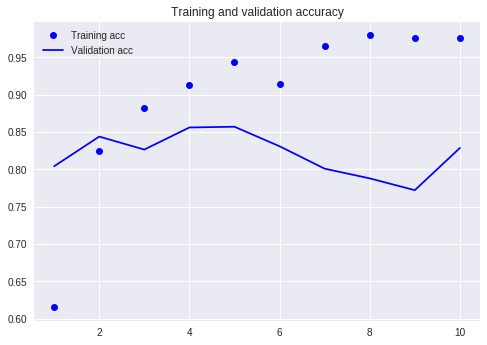

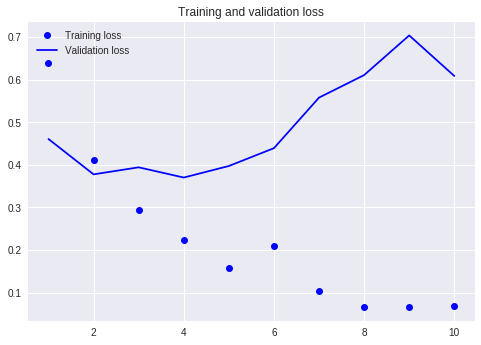

In [77]:
#Формирование графиков изменения потерь и точности в процессе обучения
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### LSTM для обработки отзывоы IMDB

In [0]:
# Листинг 6.22. Подготовка данных IMDB

from keras.datasets import imdb 
from keras.preprocessing import sequence

max_features = 10000 # Количество слов, рассматриваемых как признаки
maxlen = 500 # Обрезка текста после этого количества слов (в числе max_features самых распространенных слов)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')
print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

In [3]:
# Листинг 6.27. Использование слоя LSTM из Keras
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(input_train, 
                    y_train,epochs=10,
                    batch_size=128,
                    validation_split=0.2)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 75s 4ms/step - loss: 0.4982 - acc: 0.7682 - val_loss: 0.3998 - val_acc: 0.8286
Epoch 2/10
20000/20000 [==============================] - 73s 4ms/step - loss: 0.2974 - acc: 0.8834 - val_loss: 0.3124 - val_acc: 0.8654
Epoch 3/10
20000/20000 [==============================] - 73s 4ms/step - loss: 0.2395 - acc: 0.9093 - val_loss: 0.2839 - val_acc: 0.8804
Epoch 4/10
20000/20000 [==============================] - 74s 4ms/step - loss: 0.2016 - acc: 0.9240 - val_loss: 0.3131 - val_acc: 0.8744
Epoch 5/10
20000/20000 [==============================] - 74s 4ms/step - loss: 0.1739 - acc: 0.9358 - val_loss: 0.3244 - val_acc: 0.8872
Epoch 6/10
20000/20000 [==============================] - 73s 4ms/step - loss: 0.1617 - acc: 0.9425 - val_loss: 0.3641 - val_acc: 0.8372
Epoch 7/1

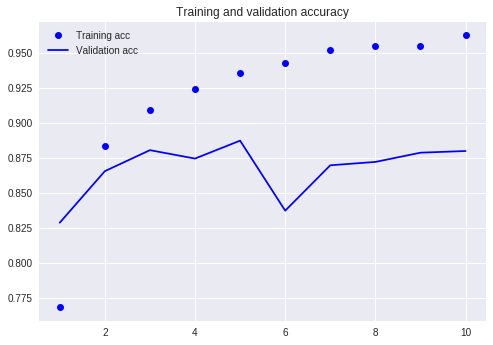

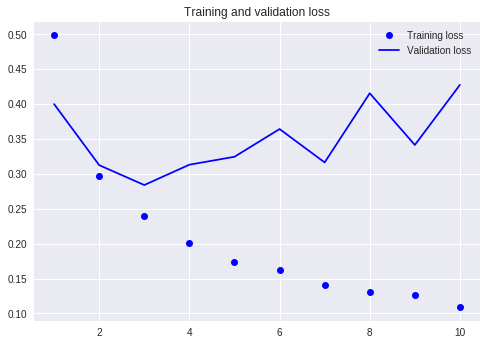

In [4]:
#Формирование графиков изменения потерь и точности в процессе обучения
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Предсказания погоды



In [0]:
!wget --no-check-certificate \
    https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip \
    -O /tmp/jena_climate_2009_2016.csv.zip

In [0]:
import os
import zipfile

local_zip = '/tmp/jena_climate_2009_2016.csv.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/data_jena_climate/')
zip_ref.close()

In [0]:
#Листинг 6.28. Обзор набора метеорологических данных Jena

import os

# tmp/data_jena_climate/jena_climate_2009_2016.csv
data_dir = '/tmp/data_jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)

header = lines[1].split(',')
lines = lines[1:]
print(header)

print(len(lines))

In [0]:
# Теперь преобразуем все 420 551 строку с данными в массив Numpy.
# Листинг 6.29. Преобразование данных
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

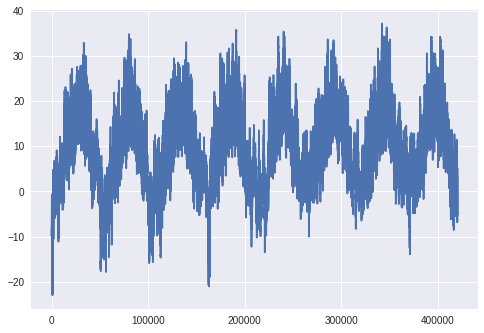

In [11]:
# Листинг 6.30. Создание графика изменения температуры
from matplotlib import pyplot as plt

temp = float_data[:, 1] # температура (в градусах Цельсия)
plt.plot(range(len(temp)), temp)

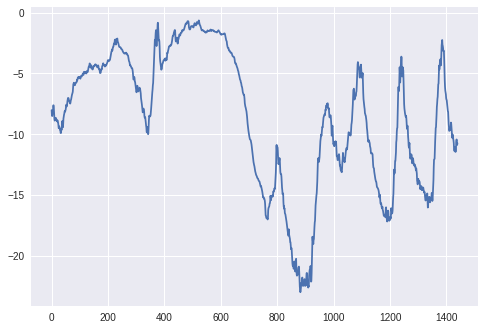

In [12]:
# Листинг 6.31. Создание графика изменения температуры по данным за первые 10 дней
plt.plot(range(1440), temp[:1440])

In [0]:
# Листинг 6.32. Нормализация данных
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [0]:
# Листинг 6.33. Функция-генератор, возвращающая временные последовательности образцов и их целей

def generator(data, # исходный массив вещественных чисел, нормализованных кодом в листинге
              lookback, # количество интервалов в прошлом от заданного момента, за которое отбираются входные данные;
              delay, # количество интервалов в будущем от заданного момента, за которое отбираются целевые данные;
              min_index, # индексы в массиве data, 
              # ограничивающие область для извлечения данных; 
              # это помогает оставить в неприкосновенности сегменты проверочных и контрольных данных;
              max_index, 
              shuffle=False, # с перемешиванием или в хронологическом порядке;
              batch_size=128, # количество образцов в пакете;
              step=6 # период в интервалах, из которого извлекается один образец;
             ):

  if max_index is None:
    max_index = len(data) - delay - 1
  
  i = min_index + lookback

  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
        
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
      
    samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
    targets = np.zeros((len(rows),))
  
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

In [0]:
# Листинг 6.34. Функции-генераторы, возвращающие обучающие, проверочные и контрольные данные

lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

#Сколько раз нужно обратиться к val_gen, 
#чтобы получить проверочный набор данных целиком
val_steps = (300000 - 200001 - lookback) // batch_size

# Сколько раз нужно обратиться к test_gen, 
# чтобы получить контрольный набор данных целиком
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [39]:
i=0
for s, tg in train_gen:
  print(s.shape,tg.shape)
  
  i+=1
  if i>=5:
    break
print(t[0][0][0])

# 128 - batch_size
# 240 - lookback = 1440 / step =6

(128, 240, 14) (128,)
(128, 240, 14) (128,)
(128, 240, 14) (128,)
(128, 240, 14) (128,)
(128, 240, 14) (128,)
[-0.11159321  1.3242194   1.32172086 -0.25098869 -2.70778991  1.46011603
 -0.45186242  2.71139443 -0.45212666 -0.45041895 -1.17805742  1.76941441
  1.19728974  0.39581674]


In [16]:
# Листинг 6.35. Оценка базового решения MAE
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))
  
evaluate_naive_method()

0.2897359729905486


In [0]:
# Листинг 6.37. Обучение и оценка полносвязной модели
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


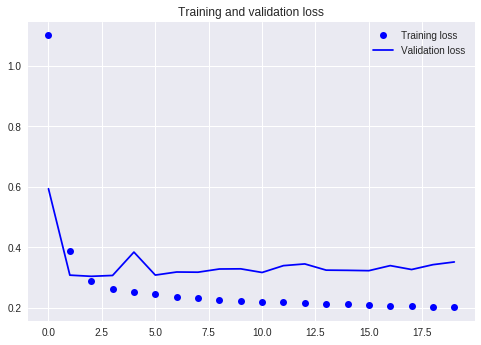

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [41]:
# Листинг 6.39. Обучение и оценка модели на основе GRU

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 107s 213ms/step - loss: 0.3039 - val_loss: 0.2749
Epoch 2/20
500/500 [==============================] - 106s 211ms/step - loss: 0.2838 - val_loss: 0.2699
Epoch 3/20
500/500 [==============================] - 106s 211ms/step - loss: 0.2771 - val_loss: 0.2729
Epoch 4/20
500/500 [==============================] - 105s 210ms/step - loss: 0.2713 - val_loss: 0.2774
Epoch 5/20
500/500 [==============================] - 105s 210ms/step - loss: 0.2680 - val_loss: 0.2846
Epoch 6/20
500/500 [==============================] - 106s 211ms/step - loss: 0.2643 - val_loss: 0.2720
Epoch 7/20
500/500 [==============================] - 105s 210ms/step - loss: 0.2587 - val_loss: 0.2707
Epoch 8/20
500/500 [==============================] - 105s 210ms/step - loss: 0.2530 - val_loss: 0.2713
Epoch 9/20
500/500 [==============================] - 105s 211ms/step - loss: 0.2484 - val_loss: 0.2834
Epoch 10/20
500/500 [==============================] - 105s 209m

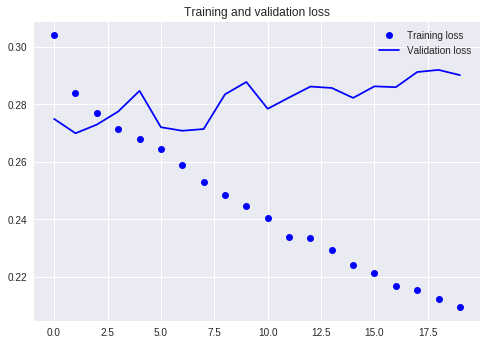

In [42]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# Листинг 6.40. Обучение и оценка модели на основе GRU
# с регуляризацией прореживанием

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/40
500/500 [==============================] - 122s 244ms/step - loss: 0.3344 - val_loss: 0.2740
Epoch 2/40
500/500 [==============================] - 120s 241ms/step - loss: 0.3150 - val_loss: 0.2748
Epoch 3/40
500/500 [==============================] - 120s 240ms/step - loss: 0.3090 - val_loss: 0.2749
Epoch 4/40
500/500 [==============================] - 120s 240ms/step - loss: 0.3043 - val_loss: 0.2688
Epoch 5/40
500/500 [==============================] - 120s 241ms/step - loss: 0.3007 - val_loss: 0.2699
Epoch 6/40
500/500 [==============================] - 121s 242ms/step - loss: 0.2999 - val_loss: 0.2664
Epoch 7/40
500/500 [==============================] - 120s 241ms/step - loss: 0.2954 - val_loss: 0.2695
Epoch 8/40
500/500 [==============================] - 120s 240ms/step - loss: 0.2936 - val_loss: 0.2669
Epoch 9/40
500/500 [==============================] -

In [0]:
# Листинг 6.41. Обучение и оценка модели с несколькими слоями GRU
# и с регуляризацией прореживанием

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))

model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))

model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [0]:
# Листинг 6.42. Обучение и оценка LSTM на обращенных последовательностях

from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

In [6]:
# Листинг 6.43. Обучение и оценка двунаправленной модели LSTM

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, 
                    y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.2
                   )

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 149s 7ms/step - loss: 0.6096 - acc: 0.6762 - val_loss: 0.5640 - val_acc: 0.7260
Epoch 2/10
20000/20000 [==============================] - 151s 8ms/step - loss: 0.3813 - acc: 0.8457 - val_loss: 0.3557 - val_acc: 0.8532
Epoch 3/10
20000/20000 [==============================] - 151s 8ms/step - loss: 0.2811 - acc: 0.8926 - val_loss: 0.3065 - val_acc: 0.8824
Epoch 4/10
20000/20000 [==============================] - 151s 8ms/step - loss: 0.2384 - acc: 0.9140 - val_loss: 0.5600 - val_acc: 0.7804
Epoch 5/10
20000/20000 [==============================] - 151s 8ms/step - loss: 0.2098 - acc: 0.9244 - val_loss: 0.3476 - val_acc: 0.8808
Epoch 6/10
20000/20000 [==============================] - 151s 8ms/step - loss: 0.1894 - acc: 0.9335 - val_loss: 0.5000 - val_acc: 0.8470
Epoch 7/10
20000/20000 [==============================] - 152s 8ms/step - loss: 0.1721 - acc: 0.9405 - val_loss: 0.3491 - v

In [0]:
# Листинг 6.44. Обучение двунаправленной модели GRU

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

### 6.4. Обработка последовательностей с помощью сверточных нейронных сетей

#### 1d CNN для отзывов IMDB

In [7]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
max_len = 500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [8]:
# Листинг 6.46. Обучение и оценка простой одномерной сверточной сети на данных IMDB

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


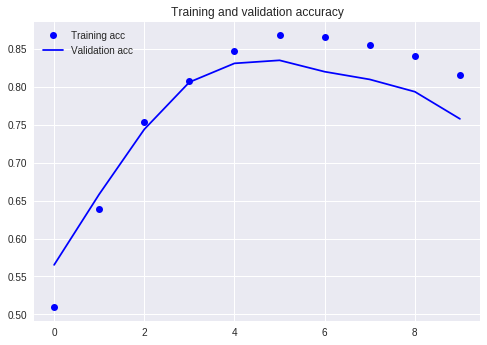

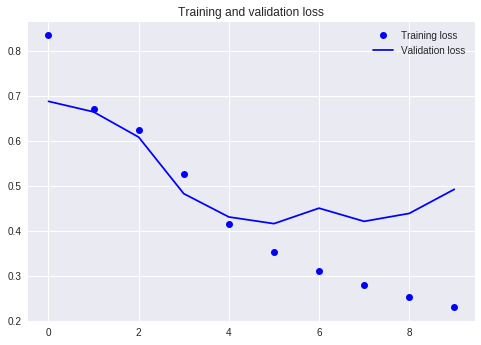

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Обучение и оценка простой 1dCNN на данных из набора Jena

In [0]:
# Листинг 6.47. Обучение и оценка простой одномерной сверточной сети на данных из набора Jena

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

#### Предсказания температуры. Модель, объединяющая одномерную сверточную основу и уровень GRU

In [0]:
# Листинг 6.48. Подготовка генераторов данных с высоким разрешением для набора данных Jena

# This was previously set to 6 (one point per hour).
# Now 3 (one point per 30 min).
step = 3
lookback = 720  # Unchanged
delay = 144 # Unchanged

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [0]:
# Листинг 6.49. Модель, объединяющая одномерную сверточную основу и уровень GRU
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)